# spacetrackのテスト その3 (gp API編)

同じ事を gp APIで取得したデータでもやってみる。

EPOCHの間隔が1秒以下のデータは省略することにした。

- EPOCHにマイクロ秒まで入るので、そのままdatetimeに変換できる。
- 項目名の変更 (APOAPSIS、PERIAPSIS など)
- 項目の追加 (CREATION_DATE、LAUNCH_DATE、COUNTRY_CODE など)

In [1]:
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
from datetime import datetime
import numpy as np
import pandas as pd
import time
import json
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# userid and password are set in here
import spacetrackaccount
# print("Login with " + spacetrackaccount.userid)

In [4]:
st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)

In [5]:
# 各columnの型
# https://www.space-track.org/basicspacedata/modeldef/class/gp/format/html も参照のこと
# decimal型のcolumnはfloat64として取り扱うことにする
dtype = {'CCSDS_OMM_VERS': str,  'COMMENT': str,  'CREATION_DATE': 'datetime64[ns]',  'ORIGINATOR': str, 
       'OBJECT_NAME': str,  'OBJECT_ID': str,  'CENTER_NAME': str,  'REF_FRAME': str, 
       'TIME_SYSTEM': str,  'MEAN_ELEMENT_THEORY': str,  'EPOCH': 'datetime64[ns]',  'MEAN_MOTION': 'float64', 
       'ECCENTRICITY': 'float64',  'INCLINATION': 'float64',  'RA_OF_ASC_NODE': 'float64', 
       'ARG_OF_PERICENTER': 'float64',  'MEAN_ANOMALY': 'float64',  'EPHEMERIS_TYPE': 'int8', 
       'CLASSIFICATION_TYPE': str,  'NORAD_CAT_ID': 'uint32',  'ELEMENT_SET_NO': 'uint16', 
       'REV_AT_EPOCH': 'uint32',  'BSTAR': 'float64',  'MEAN_MOTION_DOT': 'float64',  'MEAN_MOTION_DDOT': 'float64', 
       'SEMIMAJOR_AXIS': 'float64',  'PERIOD': 'float64',  'APOAPSIS': 'float64',  'PERIAPSIS': 'float64',  'OBJECT_TYPE': str, 
       'RCS_SIZE': str,  'COUNTRY_CODE': str,  'LAUNCH_DATE': 'datetime64[ns]',  'SITE': str,  'DECAY_DATE': 'datetime64[ns]', 
       'FILE': 'uint64',  'GP_ID': 'uint32',  'TLE_LINE0': str,  'TLE_LINE1': str,  'TLE_LINE2': str}

# 以下のcolumnは日時として解釈する (元データが空欄の場合は NaT になる)
convert_dates = ['EPOCH', 'CREATION_DATE', 'LAUNCH_DATE', 'DECAY_DATE']

In [6]:
# gp APIを用いてHinodeの軌道データをJSON形式でダウンロード (既にダウンロード済みの場合はそれを使う)
norad_cat_id = 29479
file = 'download/gp_history_{}_all.json'.format(norad_cat_id)
if not os.path.isfile(file):
    print('Downloading new data')
    data = st.gp_history(norad_cat_id=norad_cat_id, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data, convert_dates = convert_dates, dtype = dtype, precise_float = True)
else:
    print('Using pre-existing data')
    df = pd.read_json(file, convert_dates = convert_dates, dtype = dtype, precise_float = True)

Using pre-existing data


In [7]:
print(len(df))

8462


In [8]:
# orderby='epoch' として取得したためEPOCHは時間順になっているが、重複するEPOCHは存在する
dt = df['EPOCH'].diff() / pd.Timedelta(seconds = 1)
print(dt[dt < 0].index)
print(dt[dt == 0].index)

Int64Index([], dtype='int64')
Int64Index([ 907, 2134, 2435, 2469, 2621, 2771, 2786, 2788, 2848, 2928, 3012,
            3121, 3536, 5148, 5435, 5714, 5922, 5946, 6053, 6062, 6197, 6251,
            6308, 6322, 6331, 6340, 6357, 6403, 6504, 6521, 6524, 6554, 6615,
            6642, 6741, 6869, 6900, 6935, 6960, 6987, 7020, 7247, 7285, 7530,
            7801, 7835, 7908, 8068, 8078, 8104],
           dtype='int64')


In [9]:
# EPOCHの重複
df[df.duplicated(subset='EPOCH', keep=False)]

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
906,2.0,GENERATED VIA SPACE-TRACK.ORG API,2008-02-03 18:28:18,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2008-02-03 22:38:31.801631,14.628066,0.001566,98.0807,43.7624,161.6091,198.5681,0,U,29479,999,7299,0.000035,1.300000e-06,0.0,7062.267,98.440,695.191,673.073,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,507763,64948734,0 HINODE (SOLAR B),1 29479U 06041A 08034.94342363 .00000130 00000-0 34536-4 0 9990,2 29479 098.0807 043.7624 0015659 161.6091 198.5681 14.62806581 72997
907,2.0,GENERATED VIA SPACE-TRACK.ORG API,2008-02-04 09:10:28,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2008-02-03 22:38:31.801631,14.628066,0.001566,98.0807,43.7624,161.6091,198.5681,0,U,29479,999,7299,0.000035,1.300000e-06,0.0,7062.267,98.440,695.191,673.073,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,508105,64959489,0 HINODE (SOLAR B),1 29479U 06041A 08034.94342363 +.00000130 +00000-0 +34536-4 0 9990,2 29479 098.0807 043.7624 0015659 161.6091 198.5681 14.62806581072997
2133,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-12-20 16:13:28,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-12-20 22:05:58.244064,14.629399,0.001564,98.0871,355.7780,165.5832,194.5820,0,U,29479,999,17328,0.000022,6.800000e-07,0.0,7061.838,98.431,694.745,672.662,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,816424,74541666,0 HINODE (SOLAR B),1 29479U 06041A 09354.92081301 .00000068 00000-0 22395-4 0 9996,2 29479 098.0871 355.7780 0015635 165.5832 194.5820 14.62939852173280
2134,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-12-21 08:03:56,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-12-20 22:05:58.244064,14.629400,0.001561,98.0870,355.7780,165.5767,194.5887,0,U,29479,999,17328,0.000027,9.100000e-07,0.0,7061.838,98.431,694.730,672.676,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,816636,74551037,0 HINODE (SOLAR B),1 29479U 06041A 09354.92081301 +.00000091 +00000-0 +27009-4 0 9999,2 29479 098.0870 355.7780 0015615 165.5767 194.5887 14.62939961173288
2434,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-06-25 01:37:29,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-06-24 21:17:25.093536,14.629933,0.001458,98.0891,178.1342,307.9843,52.0043,0,U,29479,999,20047,0.000020,5.400000e-07,0.0,7061.666,98.428,693.824,673.238,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,918155,78362941,0 HINODE (SOLAR B),1 29479U 06041A 10175.88709599 .00000054 00000-0 19686-4 0 9994,2 29479 098.0891 178.1342 0014576 307.9843 052.0043 14.62993344200473
2435,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-06-25 09:00:21,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-06-24 21:17:25.093536,14.629933,0.001458,98.0891,178.1342,307.9843,52.0043,0,U,29479,999,20047,0.000020,5.400000e-07,0.0,7061.666,98.428,693.824,673.238,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,918281,78369796,0 HINODE (SOLAR B),1 29479U 06041A 10175.88709599 +.00000054 +00000-0 +19686-4 0 9994,2 29479 098.0891 178.1342 0014576 307.9843 052.0043 14.62993344200473
2468,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-07-16 19:56:41,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-07-16 11:59:16.490688,14.629986,0.001452,98.0902,199.3339,234.5399,125.4457,0,U,29479,999,20363,0.000017,3.800000e-07,0.0,7061.649,98.427,693.766,673.263,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,929289,78663881,0 HINODE (SOLAR B),1 29479U 06041A 10197.49949642 .00000038 00000-0 16626-4 0 9993,2 29479 098.0902 199.3339 0014517 234.5399 125.4457 14.62998598203634
2469,2.0,GENERATED VIA SPACE-TRACK.ORG API,2010-07-19 10:34:41,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2010-07-16 11

In [10]:
# EPOCHの間隔が1秒未満
print(dt[(dt > 0) & (dt < 1)].index)

Int64Index([   3,    9,   12,   14,   15,   16,   17,   19,  514,  712,  847,
             861,  933,  948, 1062, 1266, 1280, 1544, 1665, 1683, 1781, 1939,
            1993, 2059, 2081, 2594, 3748, 5969],
           dtype='int64')


In [11]:
# CREATION_DATE と EPOCH の時間差 (単位: 時間)
timelag = (df['CREATION_DATE'] - df['EPOCH']) / pd.Timedelta(hours = 1)
timelag.describe()

count    8462.000000
mean       10.456906
std        41.415045
min        -7.174662
25%         2.380248
50%         7.306549
75%        11.968160
max      1024.233163
dtype: float64

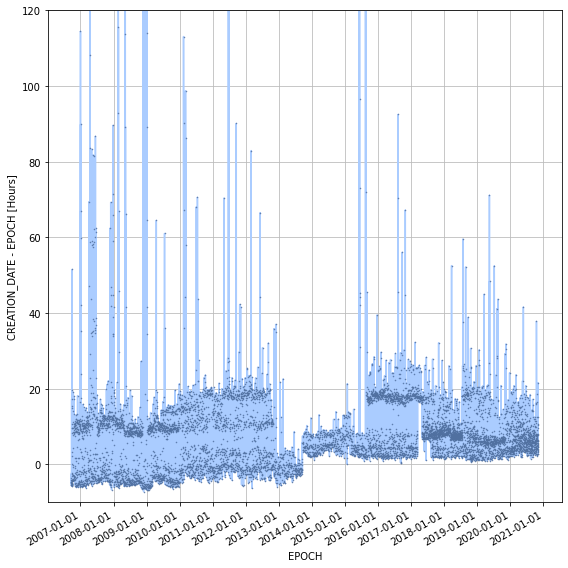

In [12]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH'], timelag, color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
ax1.set_ylim(-10, 120)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("EPOCH")
ax1.set_ylabel("CREATION_DATE - EPOCH [Hours]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [13]:
# EPOCHでソートした場合、CREATION_DATEは昇順とは限らない (重複もある)
dcreation = df['CREATION_DATE'].diff()
print(dcreation[dcreation < pd.Timedelta(0)].index)
print(df.duplicated(subset='CREATION_DATE', keep=False).sum())

Int64Index([   5,    9,   12,   15,   16,   21,   25,   35,   38,   44,
            ...
            8072, 8093, 8114, 8130, 8133, 8208, 8250, 8329, 8415, 8426],
           dtype='int64', length=1429)
65


In [14]:
# EPOCHでソートした場合、FILEは昇順とは限らない (近年のデータでは重複はない、古いデータでは重複している)
dfile = df['FILE'].diff()
print(dfile[dfile < 0].index)
print(df.duplicated(subset='FILE', keep=False).sum())

Int64Index([], dtype='int64')
0


In [15]:
# EPOCHでソートした場合、GP_IDは昇順とは限らない (重複はない)
dgpid = df['GP_ID'].diff()
print(dgpid[dgpid < 0].index)
print(df.duplicated(subset='GP_ID', keep=False).sum())

Int64Index([], dtype='int64')
0


In [16]:
# GP_IDでソートした場合、CREATION_DATE が逆転しているのは少数のデータのみ
# 「おおむね」作成順に付与されている
df2 = df.sort_values(['GP_ID', 'CREATION_DATE']).reset_index(drop=True)
dcreation2 = df2['CREATION_DATE'].diff()
print(dcreation2[dcreation2 < pd.Timedelta(0)].index)

Int64Index([1533, 1535, 1537, 1565, 1578, 1875, 1916, 1999, 2023, 2036, 2038,
            2040, 4608],
           dtype='int64')


In [17]:
df2[1532:1538]

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
1532,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-01-25 09:03:09,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-01-24 23:16:24.996864,14.628778,0.001627,98.0828,32.4488,124.0372,236.2377,0,U,29479,999,12504,0.000027,9.200000e-07,0.0,7062.038,98.436,695.392,672.415,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,663610,69645614,0 HINODE (SOLAR B),1 29479U 06041A 09024.96973376 +.00000092 +00000-0 +27078-4 0 9996,2 29479 098.0828 032.4488 0016268 124.0372 236.2377 14.62877762125041
1533,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-01-25 08:04:26,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-01-25 12:24:22.579200,14.628778,0.001631,98.0828,32.9847,122.3719,237.9053,0,U,29479,999,12512,0.000025,7.900000e-07,0.0,7062.038,98.436,695.418,672.388,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,663614,69646943,0 HINODE (SOLAR B),1 29479U 06041A 09025.51692800 .00000079 00000-0 24540-4 0 9994,2 29479 098.0828 032.9847 0016305 122.3719 237.9053 14.62877829125125
1534,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-01-26 07:47:41,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-01-25 22:15:20.797055,14.628778,0.001631,98.0828,33.3866,121.1410,239.1396,0,U,29479,999,12518,0.000021,6.200000e-07,0.0,7062.038,98.436,695.420,672.386,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,663910,69657931,0 HINODE (SOLAR B),1 29479U 06041A 09025.92732404 +.00000062 +00000-0 +21252-4 0 9993,2 29479 098.0828 033.3866 0016308 121.1410 239.1396 14.62877839125180
1535,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-01-26 07:38:06,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-01-26 13:01:48.049536,14.628781,0.001628,98.0826,33.9893,119.2315,241.0512,0,U,29479,999,12527,0.000025,8.000000e-07,0.0,7062.037,98.436,695.402,672.402,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,663973,69660456,0 HINODE (SOLAR B),1 29479U 06041A 09026.54291724 .00000080 00000-0 24712-4 0 9991,2 29479 098.0826 033.9893 0016284 119.2315 241.0512 14.62878120125275
1536,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-01-27 08:16:09,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-01-26 22:52:46.238015,14.628783,0.001631,98.0814,34.3914,118.1050,242.1809,0,U,29479,999,12533,0.000023,6.900000e-07,0.0,7062.037,98.436,695.420,672.383,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,664417,69672272,0 HINODE (SOLAR B),1 29479U 06041A 09026.95331294 +.00000069 +00000-0 +22544-4 0 9991,2 29479 098.0814 034.3914 0016310 118.1050 242.1809 14.62878258125335
1537,2.0,GENERATED VIA SPACE-TRACK.ORG API,2009-01-27 07:36:35,18 SPCS,HINODE (SOLAR B),2006-041A,EARTH,TEME,UTC,SGP4,2009-01-27 13:39:13.523327,14.628779,0.001631,98.0812,34.9942,116.1860,244.1014,0,U,29479,999,12542,0.000007,-1.000000e-07,0.0,7062.038,98.436,695.424,672.382,PAYLOAD,LARGE,JPN,2006-09-22,KSCUT,NaT,664441,69673937,0 HINODE (SOLAR B),1 29479U 06041A 09027.56890652 -.00000010 00000-0 72035-5 0 9995,2 29479 098.0812 034.9942 0016314 116.1860 244.1014 14.62877915125420


### 方針
EPOCH の時間間隔が1秒以下の時には、CREATION_DATE が新しいもの1つを残して、他は削除する。
(**必ずしもEPOCHが最新のものが残るわけではない**)

In [18]:
# EPOCH と CREATION_DATE でソートする
df = df.sort_values(['EPOCH', 'CREATION_DATE']).reset_index(drop=True)
print(len(df))

8462


In [19]:
# 隣接するデータ間でEPOCH の間隔が1秒以下のデータの個数を確認
dt = -df['EPOCH'].diff(-1) / pd.Timedelta(seconds = 1)
dt2 = df['EPOCH'].diff(1) / pd.Timedelta(seconds = 1)
flag = (dt <= 1) | (dt2 <= 1)
print(flag.sum(), 'records')
df[['EPOCH', 'CREATION_DATE']][flag].head(15)

153 records


,EPOCH,CREATION_DATE
2,2006-09-23 04:52:24.892896,2006-09-22 23:59:43
3,2006-09-23 04:52:24.932639,2006-09-23 01:22:45
8,2006-09-23 23:42:45.077472,2006-09-23 21:10:33
9,2006-09-23 23:42:45.165600,2006-09-23 19:35:36
11,2006-09-24 05:59:30.544512,2006-09-24 01:37:02
12,2006-09-24 05:59:31.426655,2006-09-24 00:19:46
13,2006-09-24 07:33:41.844960,2006-09-24 02:28:01
14,2006-09-24 07:33:41.849279,2006-09-24 05:19:35
15,2006-09-24 07:33:41.855327,2006-09-24 04:27:05
16,2006-09-24 07:33:41.895936,2006-09-24 01:49:10


In [20]:
# EPOCH間隔が1秒以上離れているデータごとにグループIDを振る (グループIDはグループの最初のインデックス値)
df['group'] = 0
nlargegroups = 0
currentgroupid = None
first_record_in_group = None
delta = pd.Timedelta(seconds = 1)
for index in df.index:
    if index == 0 or (df.at[index, 'EPOCH'] - df.at[index - 1, 'EPOCH']) > delta:
        currentgroupid = index
        first_record_in_group = True
    else:
        if first_record_in_group:
            first_record_in_group = False
            currentgroupid = index - 1
            nlargegroups += 1
            
    df.at[index, 'group'] = currentgroupid
print(nlargegroups)

75


In [21]:
df[['EPOCH', 'CREATION_DATE', 'group']].head(15)

,EPOCH,CREATION_DATE,group
0,2006-09-22 22:35:39.747263,2006-09-22 18:03:07,0
1,2006-09-23 00:09:44.819999,2006-09-22 20:05:18,1
2,2006-09-23 04:52:24.892896,2006-09-22 23:59:43,2
3,2006-09-23 04:52:24.932639,2006-09-23 01:22:45,2
4,2006-09-23 09:35:01.257504,2006-09-23 04:57:19,4
5,2006-09-23 09:35:18.004416,2006-09-23 04:13:18,5
6,2006-09-23 11:09:13.084128,2006-09-23 05:44:30,6
7,2006-09-23 20:34:22.410912,2006-09-23 16:22:21,7
8,2006-09-23 23:42:45.077472,2006-09-23 21:10:33,8
9,2006-09-23 23:42:45.165600,2006-09-23 19:35:36,8


In [22]:
df = df.sort_values(['group', 'CREATION_DATE']).drop_duplicates(subset='group', keep='last').sort_values(['EPOCH', 'CREATION_DATE']).drop('group', axis=1)

In [23]:
print(len(df))
df.head(15)

8384


,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 18:03:07,18 SPCS,TBA - TO BE ASSIGNED,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-22 22:35:39.747263,15.302105,0.029731,98.3083,274.0769,131.1804,231.6053,0,U,29479,999,0,0.000000,-0.000007,0.000002,6853.324,94.104,678.947,271.432,TBA,None,None,NaT,None,NaT,311559,58833614,0 TBA - TO BE ASSIGNED,1 29479U 06041A 06265.94143226 -.00000724 22906-5 00000+0 0 9999,2 29479 098.3083 274.0769 0297312 131.1804 231.6053 15.30210541 03
1,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-22 20:05:18,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 00:09:44.819999,15.315795,0.028316,98.3158,274.1513,130.1928,232.3173,0,U,29479,999,0,0.094972,0.092218,0.055074,6849.240,94.020,665.049,277.161,TBA,None,JPN,2006-09-22,NULL,NaT,311562,58833618,0 OBJECT A,1 29479U 06041A 06266.00676875 .09221790 55074-1 94972-1 0 9995,2 29479 098.3158 274.1513 0283162 130.1928 232.3173 15.31579544 01
3,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 01:22:45,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 04:52:24.932639,15.280796,0.029644,98.3280,274.3622,129.3552,233.4314,0,U,29479,999,4,-0.066173,-0.072046,0.008550,6859.694,94.235,684.908,278.211,TBA,None,JPN,2006-09-22,NULL,NaT,311638,58835318,0 OBJECT A,1 29479U 06041A 06266.20306635 -.07204601 85499-2 -66173-1 0 9990,2 29479 098.3280 274.3622 0296440 129.3552 233.4314 15.28079605 48
4,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 04:57:19,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 09:35:01.257504,15.297827,0.028664,98.3271,274.6004,128.2523,234.4722,0,U,29479,999,7,0.000441,0.000468,0.000003,6854.602,94.131,672.951,279.983,TBA,None,JPN,2006-09-22,NULL,NaT,311652,58835332,0 OBJECT A,1 29479U 06041A 06266.39932011 .00046819 27651-5 44140-3 0 9990,2 29479 098.3271 274.6004 0286645 128.2523 234.4722 15.29782742 78
5,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 04:13:18,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 09:35:18.004416,15.297471,0.028617,98.3221,274.6083,128.3646,235.4250,0,U,29479,999,7,-0.000764,-0.000825,0.000004,6854.709,94.133,672.735,280.412,TBA,None,JPN,2006-09-22,NULL,NaT,311651,58835331,0 OBJECT A,1 29479U 06041A 06266.39951394 -.00082503 36684-5 -76413-3 0 9991,2 29479 098.3221 274.6083 0286171 128.3646 235.4250 15.29747102 79
6,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 05:44:30,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 11:09:13.084128,15.297847,0.028663,98.3268,274.6738,128.0278,234.7212,0,U,29479,999,8,0.000368,0.000389,0.000003,6854.596,94.130,672.931,279.991,TBA,None,JPN,2006-09-22,NULL,NaT,311657,58835337,0 OBJECT A,1 29479U 06041A 06266.46473477 .00038900 26211-5 36792-3 0 9991,2 29479 098.3268 274.6738 0286625 128.0278 234.7212 15.29784717 83
7,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 16:22:21,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 20:34:22.410912,15.298010,0.028675,98.3280,275.1109,126.6928,236.1131,0,U,29479,999,14,0.000284,0.000300,0.000002,6854.547,94.129,672.970,279.855,TBA,None,JPN,2006-09-22,NULL,NaT,311841,58861789,0 OBJECT A,1 29479U 06041A 06266.85720383 .00029955 24889-5 28426-3 0 9999,2 29479 098.3280 275.1109 0286755 126.6928 236.1131 15.29801032 148
8,2.0,GENERATED VIA SPACE-TRACK.ORG API,2006-09-23 21:10:33,18 SPCS,OBJECT A,2006-041A,EARTH,TEME,UTC,SGP4,2006-09-23 23:42:45.077472,15.298159,0.028678,98.3277,275.2585,126.3160,236.5000,0,U,29479,999,16,0.000334,0.000354,0.000003,6854.503,94.128,672.943,279.792,TBA,None,JPN,2006-09-22,NULL,NaT,311912,58863227,0 OBJE

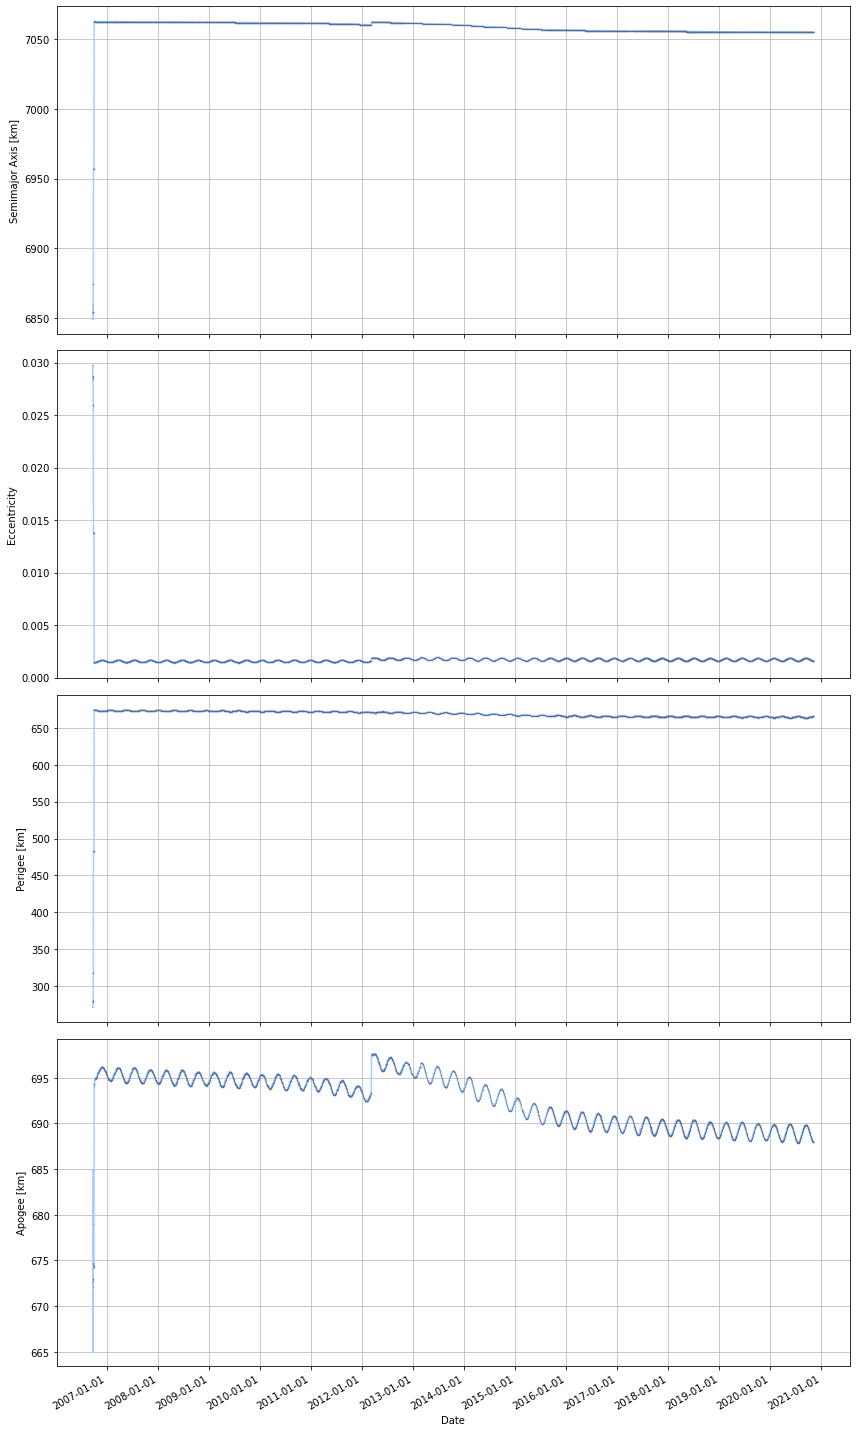

In [24]:
# 軌道長半径、離心率、近地点、遠地点の時間変化をプロット
fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(df['EPOCH'], df['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(df['EPOCH'], df['ECCENTRICITY'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Eccentricity")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(df['EPOCH'], df['PERIAPSIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Perigee [km]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(df['EPOCH'], df['APOAPSIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax4.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax4.set_xlabel("Date")
ax4.set_ylabel("Apogee [km]")
ax4.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [25]:
# 軌道長半径の時間変化
oneday = pd.Timedelta(days=1)
DT = df['EPOCH'].diff() / oneday
DSEMIMAJOR_AXIS = df['SEMIMAJOR_AXIS'].diff() / DT

In [26]:
DSEMIMAJOR_AXIS.describe()

count    8383.000000
mean        0.109091
std         6.804104
min       -62.507184
25%        -0.002437
50%        -0.001044
75%         0.000000
max       552.030129
dtype: float64

In [27]:
(DT * 86400).describe()

count      8383.000000
mean      53180.224829
std       32665.472147
min          16.746912
25%       29507.346576
50%       47280.345408
75%       76834.411057
max      402766.039872
Name: EPOCH, dtype: float64

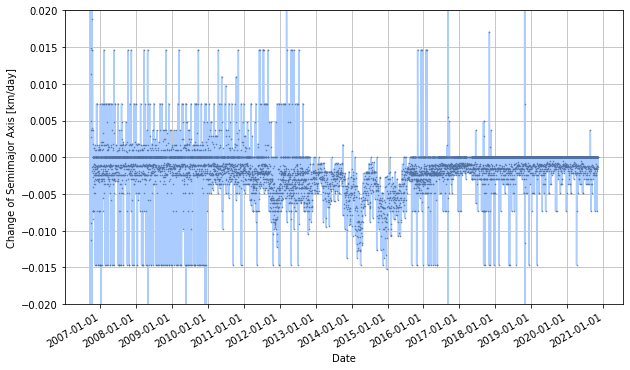

In [28]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH'], DSEMIMAJOR_AXIS, color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

ノイズが多くてよくわからないのでデータを間引く

In [29]:
# 1日平均と週平均 (EPOCHがインデックスになる)
df2 = df.resample('D', on='EPOCH').mean()
df3 = df.resample('W', on='EPOCH').mean()
print(len(df), len(df2), len(df3))

8384 5161 738


In [30]:
# 軌道長半径の時間変化
DSEMIMAJOR_AXIS2 = df2['SEMIMAJOR_AXIS'].diff()
DSEMIMAJOR_AXIS3 = df3['SEMIMAJOR_AXIS'].diff() / 7.0

In [31]:
DSEMIMAJOR_AXIS2.describe()

count    4736.000000
mean        0.042861
std         1.785100
min        -0.086857
25%        -0.002000
50%        -0.001000
75%        -0.000500
max       105.555000
Name: SEMIMAJOR_AXIS, dtype: float64

In [32]:
DSEMIMAJOR_AXIS3.describe()

count    737.000000
mean       0.038859
std        0.819281
min       -0.011524
25%       -0.002562
50%       -0.000957
75%       -0.000670
max       20.015167
Name: SEMIMAJOR_AXIS, dtype: float64

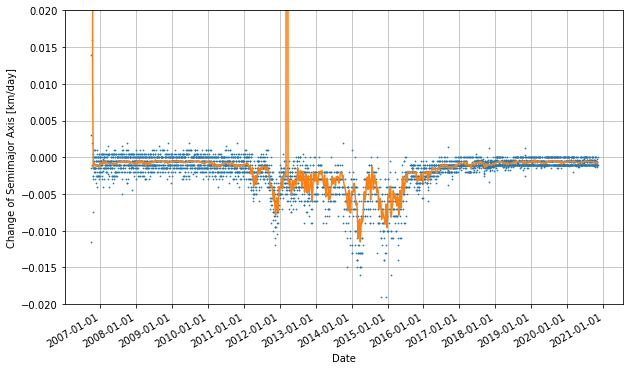

In [33]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df2.index, DSEMIMAJOR_AXIS2, '.', markersize=1.5)
ax1.plot(df3.index, DSEMIMAJOR_AXIS3)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

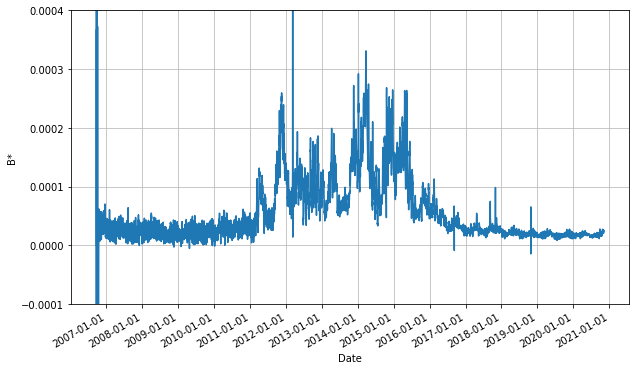

In [34]:
# 抗力項 BSTAR をプロット
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH'], df['BSTAR'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("B*")
ax1.set_ylim(-0.0001, 0.0004)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()